# Segmenting and Clustering Neighborhoods in Toronto
Course: Applied Data Science Capstone (Week 3)

We start with importing the relevant libraries.

In [135]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import geocoder # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

# to scrape the table from the page
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
from urllib.request import urlopen

Libraries imported.


## 1. Scrape the table from the webpage
Here we will use BeautifulSoup to get the table.

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')

In [4]:
#extract all tables
tables = soup.find_all('table')

After inspecting the results we find that 3 tables were extracted from the page. The first table is the one we want. And in the table, each row is under `<tr>` tag and each cell is under `<td>` tag. Below we extract the value from each cell and store them in three lists: PostalCode, Borough, and Neighborhood. In the process, boroughs that are __"Not assigned"__ are dropped. And cells that have a borough but __Not assigned__ neighborhood would use the borough value as the neighborhood.

In [5]:
#Arrays to hold extracted data
PostalCode = []
Borough = []
Neighborhood = []
table = tables[0]

rows = table.find_all('tr')
for row in rows:
    cells = row.find_all('td') # this would return empty for the header row
    
    if len(cells)>1:
        # extract the text of cells and strip the '\n' at the end
        postal = cells[0].text.strip('\n')
        borough = cells[1].text.strip('\n')
        neighborhood = cells[2].text.strip('\n')
        
        # skip cells with an unassigned borough
        if borough == 'Not assigned':
            continue
        
        PostalCode.append(postal)
        Borough.append(borough)
        if neighborhood == 'Not assigned':
            neighborhood = borough
        Neighborhood.append(neighborhood)
        

Once we have the lists, we can construct a dataframe. We also print out the first 10 rows of the dataframe so we can check if things worked.

In [6]:
#Construct dataframe
d = {'PostalCode':PostalCode, 'Borough':Borough, 'Neighborhood':Neighborhood}
df = pd.DataFrame(d)
df.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


The cell below would print information about the number of rows in the dataframe.

In [7]:
print('There are {} rows of {} variables in the dataframe'.format(df.shape[0],df.shape[1]))

There are 103 rows of 3 variables in the dataframe


## 2. Adding the coordinates
We are going to use the geocoder package here. Thanks to the suggestion of Chin Jun Hong in the discussion, the arcgis API works.
First we create two lists to hold the latitude and longitude values. Then we assign them to the new columns.

In [23]:
lngs = []
lats = []

for p in df.PostalCode.unique():
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(p))
        lat_lng_coords = g.latlng

    lats.append(lat_lng_coords[0])
    lngs.append(lat_lng_coords[1])


In [24]:
df['Latitude'] =  lats
df['Longitude'] = lngs
df.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.66263,-79.52831
6,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662
7,M3B,North York,Don Mills,43.74923,-79.36186
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.70718,-79.31192
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804


## 3. Explore and cluster the neighborhoods
For this part we follow the example from the lab. And for now, we will only work with boroughs that have the word 'Toronto'.
### 3.1 Visualize the boroughs/neighborhoods on a map
#### Get the latitude and longitude values of Toronto

In [25]:
locator = geocoder.arcgis('Toronto, Ontario')
coords= locator.latlng
latitude = coords[0]
longitude = coords[1]
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.648690000000045, -79.38543999999996.


#### Create a map near Toronto with all neighborhoods superimposed on top

In [176]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)

map_toronto

#### Extract only boroughs containing "Toronto"
First we create a new dataframe for the Toronto only data.

In [72]:
toronto_df = df[df["Borough"].str.contains('Toronto')].reset_index(drop = True)
print(toronto_df.shape)
toronto_df.tail()

(39, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
34,M5W,Downtown Toronto,Stn A PO Boxes,43.64869,-79.38544
35,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.66788,-79.36649
36,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.64828,-79.38146
37,M4Y,Downtown Toronto,Church and Wellesley,43.66659,-79.38133
38,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.64869,-79.38544


Let's visualize these neighborhoods on the map. A seperate map is created.

In [178]:
# create map of Toronto using latitude and longitude values
map_toronto_2 = folium.Map(location=[latitude, longitude], zoom_start=10, control_scale = True)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_2)

map_toronto_2

### 3.2 Exploring the neighborhoods with Foursquare
Next we utilize the Foursquare API to explore the neighborhoods.
#### Define Foursquare credentials and version

In [30]:
CLIENT_ID = 'XFVT2UT45J33O0UT1SRHDRYXUECK3ZAMRFHSTTOA3OO5I4AW' # your Foursquare ID
CLIENT_SECRET = 'ORTABQR5CETDWAL0GZV2LNP01FDZSM15VEMFGB3V2LE0ZLTC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XFVT2UT45J33O0UT1SRHDRYXUECK3ZAMRFHSTTOA3OO5I4AW
CLIENT_SECRET:ORTABQR5CETDWAL0GZV2LNP01FDZSM15VEMFGB3V2LE0ZLTC


#### Explore the first neighborhood
Just like in the lab. Let's explore the first neighborhood in the toronto only dataframe.

First, we get the information on the first neighborhood.

In [32]:
neighborhood_name = toronto_df.loc[0,'Neighborhood'] # name
neighborhood_lat = toronto_df.loc[0, 'Latitude'] # latitude
neighborhood_lng = toronto_df.loc[0, 'Longitude'] # longitude

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_lat, 
                                                               neighborhood_lng))

Latitude and longitude values of Regent Park, Harbourfront are 43.65512000000007, -79.36263999999994.


Next we get the top 100 venues in the area within a radius of 500 meters.

In [179]:
#Create the request url
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(\
                                                                                                                           CLIENT_ID,
                                                                                                                           CLIENT_SECRET,
                                                                                                                           VERSION,
                                                                                                                           neighborhood_lat,
                                                                                                                           neighborhood_lng,
                                                                                                                           radius,
                                                                                                                           LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=XFVT2UT45J33O0UT1SRHDRYXUECK3ZAMRFHSTTOA3OO5I4AW&client_secret=ORTABQR5CETDWAL0GZV2LNP01FDZSM15VEMFGB3V2LE0ZLTC&v=20180605&ll=43.65512000000007,-79.36263999999994&radius=500&limit=100'

In [180]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5facb5812158a34dc81b1019'},
 'response': {'headerLocation': 'Corktown',
  'headerFullLocation': 'Corktown, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 20,
  'suggestedBounds': {'ne': {'lat': 43.65962000450007,
    'lng': -79.3564319112327},
   'sw': {'lat': 43.650619995500065, 'lng': -79.36884808876718}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54ea41ad498e9a11e9e13308',
       'name': 'Roselle Desserts',
       'location': {'address': '362 King St E',
        'crossStreet': 'Trinity St',
        'lat': 43.653446723052674,
        'lng': -79.3620167174383,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.653446723052674,
          'lng': -79.3620167174383}],
        'distance':

We use the `get_category_type` function from the Foursquare lab and clean the json, turning it into a dataframe.

In [38]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [43]:
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten json

# filter columns
filtered_columns = ['venue.name','venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis = 1)

# clean_columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Figs Breakfast & Lunch,Breakfast Spot,43.655675,-79.364503
3,The Yoga Lounge,Yoga Studio,43.655515,-79.364955
4,Body Blitz Spa East,Spa,43.654735,-79.359874


In [44]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

20 venues were returned by Foursquare.


#### Explore all the neighborhoods in Toronto
We write a function to repeat the process above on all the neighborhoods in Toronto.

In [45]:
def getNearbyVenues(names, latitudes, longitudes, radius = 500):
    # default radius is 500 meters
    
    venues = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name) # check the neighborhoods processed, maybe comment out later
        
        # create the request url
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(\
                                                                                                                           CLIENT_ID,
                                                                                                                           CLIENT_SECRET,
                                                                                                                           VERSION,
                                                                                                                           lat,
                                                                                                                           lng,
                                                                                                                           radius,
                                                                                                                           LIMIT)
        
        # make the request and extract the venues
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return the relevant information
        venues.append([(name, 
                       lat, 
                       lng, 
                       v['venue']['name'], 
                       v['venue']['location']['lat'], 
                       v['venue']['location']['lng'], 
                       v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue in venues for item in venue])
    nearby_venues.columns = ['Neighborhood',
                            'Neighborhood Latitude',
                            'Neighborhood Longitude',
                            'Venue',
                            'Venue Latitude',
                            'Venue Longitude',
                            'Venue Category']
    
    return nearby_venues

Apply the function to all neighborhoods.

In [46]:
toronto_venues = getNearbyVenues(names = toronto_df['Neighborhood'], latitudes = toronto_df['Latitude'], longitudes = toronto_df['Longitude'])

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


In [75]:
print(toronto_venues.shape)
print(toronto_venues.Neighborhood.unique().shape)
toronto_venues.head()

(1738, 7)
(38,)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65512,-79.36264,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65512,-79.36264,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65512,-79.36264,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot
3,"Regent Park, Harbourfront",43.65512,-79.36264,The Yoga Lounge,43.655515,-79.364955,Yoga Studio
4,"Regent Park, Harbourfront",43.65512,-79.36264,Body Blitz Spa East,43.654735,-79.359874,Spa


One neighborhood is missing from the returned dataframe. Let's double check.

In [78]:
set(toronto_df['Neighborhood'].tolist())-set(toronto_venues.Neighborhood.unique().tolist())

{'Roselawn'}

In [98]:
roselawn_latlng = toronto_df.loc[toronto_df['Neighborhood'] == 'Roselawn', ['Latitude','Longitude']].reset_index(drop = True)
roselawn_lat = roselawn_latlng.loc[0,'Latitude']# latitude
roselawn_lng = roselawn_latlng.loc[0,'Longitude'] # longitude

print('Latitude and longitude values of {} are {}, {}.'.format('Roselawn', 
                                                               roselawn_lat, 
                                                               roselawn_lng))


Latitude and longitude values of Roselawn are 43.71208000000007, -79.41847999999999.


In [181]:
#getNearbyVenues(names = ['Roselawn'], latitudes = [roselawn_lat], longitudes = [roselawn_lng])
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(\
                                                                                                                           CLIENT_ID,
                                                                                                                           CLIENT_SECRET,
                                                                                                                           VERSION,
                                                                                                                           roselawn_lat,
                                                                                                                           roselawn_lng,
                                                                                                                           radius,
                                                                                                                           LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=XFVT2UT45J33O0UT1SRHDRYXUECK3ZAMRFHSTTOA3OO5I4AW&client_secret=ORTABQR5CETDWAL0GZV2LNP01FDZSM15VEMFGB3V2LE0ZLTC&v=20180605&ll=43.71208000000007,-79.41847999999999&radius=500&limit=100'

In [182]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5facb593164c641f7b8fe159'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Lawrence Park South',
  'headerFullLocation': 'Lawrence Park South, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 0,
  'suggestedBounds': {'ne': {'lat': 43.716580004500074,
    'lng': -79.41226601400064},
   'sw': {'lat': 43.70757999550007, 'lng': -79.42469398599934}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': []}]}}

__The search returned no venues within 500 meters radius of Roselawn.__

In [48]:
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 229 unique categories.


### 3.3 Analyze the neighborhoods
Now lets analyze the neighborhoods and see how the venues distribute.

There are two thing to notice here.
1. There is a category __"Neighborhood"__ so we would add the neighborhood names back as column "Neighborhood Name".
2. There are only 38 unique neighborhood values compared to the 39 in the original dataframe. One neighborhood, Roselawn, didn't have any venue result within 500 meters, which is certainly special. For the completeness, we add Roselawn back later in section 3.4, to the feature matrix, with 0 for all frequencies.

#### One-hot encoding
Just like the example from the lab. We use a one-hot encoding for the categories. 

In [65]:
toronto_venues[['Venue Category']].isin(['Neighborhood']).sum()

Venue Category    6
dtype: int64

In [64]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix = "", prefix_sep = "")

# add neighborhood names
toronto_onehot['Neighborhood Name'] = toronto_venues['Neighborhood']

# move the neighborhood names to the front
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood Name,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [66]:
toronto_onehot.shape

(1738, 230)

#### How common are different types of venues within different neighborhoods?
Next we group by neighborhood and taking the mean of the frequecy of occurance of categories.

In [184]:
toronto_grouped = toronto_onehot.groupby('Neighborhood Name').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head()

(38, 230)


,Neighborhood Name,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.0,0.00,0.016667,0.0,0.016667,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.016667,0.033333,0.000000,0.000000,0.0,0.033333,0.0,0.0,0.0,0.016667,0.0,0.000000,0.0,0.00,0.033333,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.016667,0.0,0.0,0.000000,0.033333,0.0,0.000000,0.000000,0.000000,0.033333,0.083333,0.0,0.000000,0.0,0.0,0.016667,0.000000,0.016667,0.0,0.000000,0.00,0.016667,0.0,0.0,0.000000,0.0,0.016667,0.000000,0.0,0.016667,0.000000,0.0,0.0,0.0,0.0,0.016667,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.033333,0.000000,0.0,0.016667,0.0,0.0,0.000000,0.0,0.00,0.016667,0.016667,0.016667,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.

We are not going to add Roselawn back yet. Let take a look at the top 5 most common types of venues.

In [115]:
num_of_top_venues = 5

for hood in toronto_grouped['Neighborhood Name']:
    print('-----'+hood+'-----')
    
    temp = toronto_grouped[toronto_grouped['Neighborhood Name']==hood].T.reset_index()
    
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] =  temp['freq'].astype(float)
    temp = temp.round({'freq':2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_of_top_venues))
    print('\n')

-----Berczy Park-----
            venue  freq
0     Coffee Shop  0.08
1     Cheese Shop  0.03
2  Breakfast Spot  0.03
3    Cocktail Bar  0.03
4        Beer Bar  0.03


-----Brockton, Parkdale Village, Exhibition Place-----
            venue  freq
0     Coffee Shop  0.06
1            Café  0.06
2             Bar  0.06
3      Restaurant  0.05
4  Sandwich Place  0.04


-----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto-----
              venue  freq
0       Coffee Shop  0.10
1             Hotel  0.05
2        Restaurant  0.04
3              Café  0.03
4  Asian Restaurant  0.03


-----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport-----
                venue  freq
0  Italian Restaurant  0.08
1         Coffee Shop  0.07
2                Café  0.07
3   French Restaurant  0.04
4                Park  0.04


-----Central Bay Street-----
            venue  freq
0     Coffee Shop  0.12
1  Clothing St

Next we create a dataframe to hold the top 10 venues for each neighborhood. Later we can check this dataframe to see if we can discern the logic behind the clustering.

In [117]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [203]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood Name']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Farmers Market,Beer Bar,Breakfast Spot,Cocktail Bar,Restaurant,Cheese Shop,Bakery,Seafood Restaurant,Lounge
1,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Bar,Café,Restaurant,Gift Shop,Sandwich Place,Nightclub,Japanese Restaurant,Supermarket,Furniture / Home Store
2,"Business reply mail Processing Centre, South C...",Coffee Shop,Hotel,Restaurant,Café,Italian Restaurant,Bar,Asian Restaurant,Salon / Barbershop,Thai Restaurant,Pub
3,"CN Tower, King and Spadina, Railway Lands, Har...",Italian Restaurant,Café,Coffee Shop,Bar,Park,French Restaurant,Lounge,Sandwich Place,Restaurant,Gym / Fitness Center
4,Central Bay Street,Coffee Shop,Clothing Store,Restaurant,Sandwich Place,Sushi Restaurant,Café,Plaza,Bubble Tea Shop,Cosmetics Shop,Bookstore


Now let's add Roselawn here with Null values for all venue options.

In [204]:
row = ['Roselawn'] + [np.nan]*10 # there are 11 columns

neighborhoods_venues_sorted.loc[38] = row # there are 38 neighborhoods already in the dataframe
neighborhoods_venues_sorted.tail()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,The Beaches,Health Food Store,Pub,Trail,Neighborhood,Yoga Studio,Eastern European Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm
35,"The Danforth West, Riverdale",Intersection,Bus Line,Business Service,Coffee Shop,Park,Ice Cream Shop,Grocery Store,Discount Store,Farmers Market,Event Space
36,"Toronto Dominion Centre, Design Exchange",Coffee Shop,Hotel,Restaurant,Café,Salad Place,American Restaurant,Japanese Restaurant,Seafood Restaurant,Concert Hall,Sporting Goods Shop
37,"University of Toronto, Harbord",Café,Coffee Shop,Bakery,Bookstore,Japanese Restaurant,Restaurant,Bar,Gym,Yoga Studio,College Arts Building
38,Roselawn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.4 Clustering the neighborhoods
#### Try it with 5 clusters
We need to add Roselawn back to the feature matrix. Then we can run k-means to cluster the neighborhoods. Let's try 5 clusters.

In [205]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood Name', 1)
toronto_grouped_clustering.loc[38] = [0]*229

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Now we add the labels and the top 10 venues to a dataframe.

In [206]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,1,Coffee Shop,Breakfast Spot,Yoga Studio,Theater,Pub,Distribution Center,Restaurant,Electronics Store,Event Space,Food Truck
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188,1,Coffee Shop,Sandwich Place,Mediterranean Restaurant,Italian Restaurant,Café,Falafel Restaurant,Fried Chicken Joint,Bank,Theater,Gastropub
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804,1,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Japanese Restaurant,Furniture / Home Store,Theater,Ramen Restaurant,Bookstore,Movie Theater
3,M5C,Downtown Toronto,St. James Town,43.65215,-79.37587,1,Coffee Shop,Cocktail Bar,Cosmetics Shop,Gastropub,Clothing Store,Restaurant,Café,Hotel,Japanese Restaurant,Beer Bar
4,M4E,East Toronto,The Beaches,43.67709,-79.29547,1,Health Food Store,Pub,Trail,Neighborhood,Yoga Studio,Eastern European Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm


In [207]:
# Check Roselawn
toronto_merged[toronto_merged['Neighborhood']=='Roselawn']

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,M5N,Central Toronto,Roselawn,43.71208,-79.41848,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Visualize the clusters

In [208]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Is there a best number of clusters?
There might not be clear clusters. So we can feel free to choose a number of clusters that suits our needs. We use the elbow method to try to check whether there is a "best" number of clusters.

Text(0, 0.5, 'Sum of squared distance')

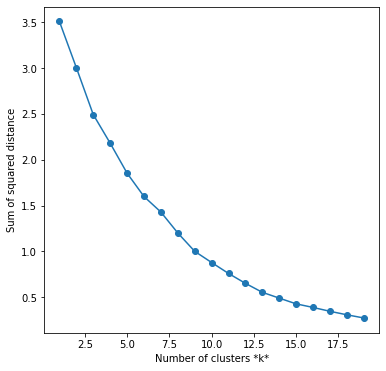

In [209]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k, random_state = 0)
    km.fit(toronto_grouped_clustering)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

Given that there are a total number of 38 neighborhoods and there isn't an elbow point (where the change of inertia value has a significant decrease) for up to 19 clusters. We can conclude that instead of clearly separated clusters, we can segment the neighborhoods into a number of groups that would suit our need.

### 3.5 Examine the clusters
From the map, we can see that most neighborhoods were labeled 1. And 3 of the 5 clusters only have one neighborhood. Let's check neighborhoods in each cluster.
#### Cluster 0

In [210]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Lawrence Park,Bus Line,Swim School,Yoga Studio,Elementary School,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm


#### Cluster 1
It's worth noticing that Roselawn is in this cluster.

In [211]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Regent Park, Harbourfront",Coffee Shop,Breakfast Spot,Yoga Studio,Theater,Pub,Distribution Center,Restaurant,Electronics Store,Event Space,Food Truck
1,"Queen's Park, Ontario Provincial Government",Coffee Shop,Sandwich Place,Mediterranean Restaurant,Italian Restaurant,Café,Falafel Restaurant,Fried Chicken Joint,Bank,Theater,Gastropub
2,"Garden District, Ryerson",Coffee Shop,Clothing Store,Café,Cosmetics Shop,Japanese Restaurant,Furniture / Home Store,Theater,Ramen Restaurant,Bookstore,Movie Theater
3,St. James Town,Coffee Shop,Cocktail Bar,Cosmetics Shop,Gastropub,Clothing Store,Restaurant,Café,Hotel,Japanese Restaurant,Beer Bar
4,The Beaches,Health Food Store,Pub,Trail,Neighborhood,Yoga Studio,Eastern European Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm
5,Berczy Park,Coffee Shop,Farmers Market,Beer Bar,Breakfast Spot,Cocktail Bar,Restaurant,Cheese Shop,Bakery,Seafood Restaurant,Lounge
6,Central Bay Street,Coffee Shop,Clothing Store,Restaurant,Sandwich Place,Sushi Restaurant,Café,Plaza,Bubble Tea Shop,Cosmetics Shop,Bookstore
7,Christie,Café,Grocery Store,Coffee Shop,Playground,Candy Store,Athletics & Sports,Italian Restaurant,Baby Store,Farm,Escape Room
8,"Richmond, Adelaide, King",Hotel,Coffee Shop,Café,Restaurant,Japanese Restaurant,Gym,American Restaurant,Salad Place,Steakhouse,Asian Restaurant
9,"Dufferin, Dovercourt Village",Park,Grocery Store,Middle Eastern Restaurant,Brazilian Restaurant,Café,Bar,Bank,Bakery,Athletics & Sports,Furniture / Home Store


#### Cluster 2

In [170]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,"Forest Hill North & West, Forest Hill Road Park",French Restaurant,Park,Yoga Studio,Electronics Store,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm


#### Cluster 3

In [171]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,"North Toronto West, Lawrence Park",Playground,Gym Pool,Park,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
33,Rosedale,Playground,Tennis Court,Park,Bike Trail,Shop & Service,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


#### Cluster 4

In [172]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,"Moore Park, Summerhill East",Playground,Gym,Trail,Dumpling Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
